In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
#Unzip onto Google drive for use in Colab
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Colab Notebooks/lfw'

path = '/content/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
#Google Colab uses cuda device, set it here
if torch.backends.cuda.is_built():
    device = torch.device("cuda:0")
else:
    print ("Cuda device not found.")

torch.Size([250, 250, 3])


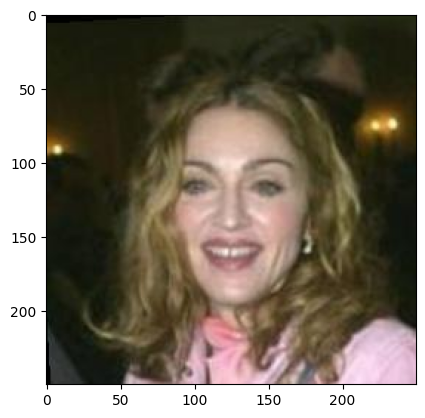

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

## Differences AE vs VAEs

Autoencoders and Variational AutoEncoders differ in a few key ways. They both have models that reduce the dimensionality of the input and rebuild from the lower dimensional space, with an encoder-decoder architecture. but Variational AEs have additional abilities in new data generation.

In applications, AEs learn to reconstruct their inputs, and are good image compression, and also denoising and anomaly detection. VAEs also reduce dimensions, and can do all that AEs do, but they can be trained to generate new data similar to the input training data. So they can do image synthesis, or make new music or text depeding on the input type. VAEs also capture more data about the latent representation of the inputs, and can reveal more relationships and learning because of that.

In architecture, both have the encoder-decoder architecture, but an AE is simpler. An AE encoder maps the input data to a fixed dimension latent space, and its decoder reconstructs the input from the latent space. In a VAE, the input is mapped to a multivariate normal ( or gaussian, etc. )distribution in the latent space, and the decoder takes samples from the latent distribution and makes new data points.

Loss function differences between AE and VAE come from the different goals of the model learning. A regular AE just wants to measure the difference between the original input and the reconstructed result and score the similarity. A VAE loss function includes the reconstruction error and a KL divergence term that encourages diverse output. The KL regularization term measures how different the distribution learned is to the prior distribution, the approximate posterior learned by the encoder and a chosen prior distribution, generating better data.

VAEs are better for data generation and interpreting the latent space.



# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [31]:
class VAE(nn.Module):

    def __init__(self):
        super(VAE,self).__init__()
    #def encoder(self,x):
    #def decoder(self,x):
    #def forward(self,x):
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(32, 16, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2

            #Mean of latent space
            #mu, logvar =
            #Log variance of latent space

        )

    def encode(self, x):
        #calculate mean and log variance of latent space calculated
        #mu = self.fc21(h1)
        #logvar = self.fc22(h1)
        h  = self.encoder(x)
        mu, logvar = h.split(h.size(1)//2, 1)
        return mu, logvar

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 6, stride=2, padding=0),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
      # call encoder function
        h   = self.encoder(x)
        #mu, logvar
        #
        out = self.decoder(h)
        return out



## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [32]:
model = VAE().to(device)

In [33]:
for data in dataloader:
  img,y = data
  #Flatten the image when necessary
  #img = img.view(img.size(0), -1)

  #This line puts the variable on the gpu device
  img = img.to(device)
  #img = Variable(img).cuda()

  out_encoder = model.encoder(img)
  print("Shape of output of encoder layers: ", out_encoder.shape)

  out_mu, out_logvar = model.encode(img)
  print("Shape of encoder mu: ", out_mu.shape)
  print("Shape of encoder logvar: ", out_logvar.shape)



  #out_decoder = model.decoder(out_encoder)
  #print("Shape of output of decoder: ", out_decoder.shape)

  #output = model.forward(img)
  #print("Output shape of forward path, same as decoder:",output.size())

  break

Shape of output of encoder:  torch.Size([32, 16, 20, 20])
Shape of mu:  torch.Size([32, 8, 20, 20])
Shape of logvar:  torch.Size([32, 8, 20, 20])


## Generating new samples
  The method for calculating new samples

  The formula

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [15]:
#Total number of parameters
print("Total number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of parameters: 10763


In [16]:
#The optimizer for training, is Adam again
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [17]:
loss_function = nn.MSELoss()

The terms of the loss function are

Each term achieves

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [28]:
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        img = img.to(device)

        # ===================forward=====================

        param_f = model.encoder(img)

        #Calculating the mean and log variance
        mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)

        #The KL divergence
        kl = - 0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
        kl_loss = kl.sum() / img.size(0)

        std_f = torch.exp(0.5 * logvar_f)
        z = torch.randn_like(mu_f) * std_f + mu_f
        #print(z.shape)
        output = model.decoder(z)

        #Loss function
        fit = 0.5 * (output - img).pow(2)
        fit_loss = fit.sum() / img.size(0)
        loss = kl_loss + fit_loss

        #if epoch == 1:
         # print("Fit:",fit.shape)
         # print("fit_loss:",fit)
         # print("loss1:",loss)

        loss = loss_function(output, img)
        if epoch == 1:
          print("loss2:",loss)



        # ===================backward====================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data

    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))

epoch [1/10], loss:3.1362
loss2: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)
loss2: tensor(0.0081, device='cuda:0

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


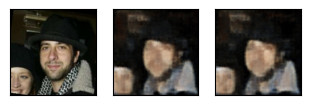

In [29]:
def to_img(x):
    #x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 250, 250)
    return x

def plot_image_pair(x,y, yn):

    #plt.axis.remove()

    #Display original
    plt.subplot(151)
    plt.xticks([])
    plt.yticks([])
    x = x[0].permute(1, 2, 0)
    plt.imshow(x)

    #Display generated
    plt.subplot(152)
    plt.xticks([])
    plt.yticks([])
    y1 = y[0].permute(1, 2, 0)
    plt.imshow(y1)

    #Display other generated
    plt.subplot(153)
    plt.xticks([])
    plt.yticks([])
    #print("passed:",y.size())
    y2 = yn[0].permute(1, 2, 0)
    plt.imshow(y2)

    #plt.subplot(154)
    #y3 = y[2].permute(1, 2, 0)
    #plt.imshow(y3)

    #plt.subplot(155)
    #y4 = y[0].permute(1, 2, 0)
    #plt.imshow(y4)

def variation(img):
  param_f = model.encoder(img)
  mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)
  kl = - 0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
  kl_loss = kl.sum() / img.size(0)
  std_f = torch.exp(0.5 * logvar_f)
  z = torch.randn_like(mu_f) * std_f + mu_f
  output = model.decoder(z)
  return output

for img,y in dataloader:
  x = img
  #img = img.view(img.size(0), -1)
  img = Variable(img).cuda()

#############
  param_f = model.encoder(img)
  mu_f, logvar_f = param_f.split(param_f.size(1)//2, 1)
  kl = - 0.5 * (1 + logvar_f - mu_f.pow(2) - logvar_f.exp())
  kl_loss = kl.sum() / img.size(0)
  std_f = torch.exp(0.5 * logvar_f)

  z = torch.randn_like(mu_f) * std_f + mu_f
  #print(z.shape)
  output = model.decoder(z)
  print(output.size())
#############
  output2 = variation(img)

  #output = model(img)

  xt = to_img(output.cpu().data)
  print(xt.size())
  xt2 = to_img(output2.cpu().data)
  print(xt2.size())

  xt_list = []
  xt_list.append(xt[0])
  xt_list.append(xt2[0])

  #print("img:",xt.size())
  plot_image_pair(x, xt,xt2)
  break

In [ ]:

plt.imshow()